In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from musicautobot.imports import *
from musicautobot.numpy_encode import *
from musicautobot.vocab import *
from musicautobot.music_transformer.transform import *
from musicautobot.music_transformer.dataloader import *

In [3]:
from fastai.text.all import *

In [4]:
torch.cuda.set_device(5)

## MusicTransformer Training

MusicTransformer takes the basic idea of [Language Models](https://en.wikipedia.org/wiki/Language_model) and applies it to Music.  

Given a sequence of notes, predict the next most likely set of notes.

This model is based off of [transformer-XL](https://arxiv.org/abs/1901.02860) and uses fast.ai's [implementation](https://github.com/fastai/fastai/blob/master/fastai/text/models/transformer.py) of it.

In [5]:
# base_path = Path('../../data')

# # Location of your midi files
# midi_path = base_path/'midi/examples'
# midi_path.mkdir(parents=True, exist_ok=True)

# # Location to save dataset
# data_path = base_path/'numpy'
# data_path.mkdir(parents=True, exist_ok=True)

# data_save_name = 'musicitem_data_save.pkl'

In [6]:
base_path = Path('../../data/v20')
midi_path = base_path/'midi_sources/hooktheory'

data_path = base_path/'piano_duet/hooktheory'


## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

## 2. Create dataset from MIDI files

In [7]:
vocab = MusicVocab.create()
np_files = get_files(data_path, '.npy', recurse=True)[:400]; 
len(np_files)

400

In [8]:
subset = np_files
# tfms = [MusicItemTfm(vocab), rand_transpose, mi2tensor]
tfms = [MusicItemTfm(vocab), rand_transpose, lambda x: x.data]
splits = RandomSplitter(seed=42)(range(len(subset)))
dsets = Datasets(subset, [tfms], splits=splits, dl_type=LMDataLoader)

## We rely on lru_cache to make sure random_transform doesn't get called twice on the same sequence.
Theoretically, setting cache to batch size should never result in a cache miss. Every sequence should be called once per batch. However, let's quadruple it just to be safe

In [9]:
bs = 16
dls = dsets.dataloaders(path=base_path, bs=bs, seq_len=512, cache=bs*4).cuda()

## 3. Load Model

In [10]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [11]:
from transformers import TransfoXLLMHeadModel, TransfoXLConfig

In [12]:

def default_config():
    config = tfmerXL_lm_config.copy()
    config['act'] = Activation.GeLU

    config['mem_len'] = 512
    config['d_model'] = 512
    config['d_inner'] = 2048
    config['n_layers'] = 16

    config['n_heads'] = 8
    config['d_head'] = 64

    return config


In [13]:
config = TransfoXLConfig(
    vocab_size=len(vocab), cutoffs=[],
    d_model=512, d_embed=512,
    n_head=8, d_head=64, 
    d_inner=2048, n_layer=16, 
    mem_len=512)

In [14]:
model = TransfoXLLMHeadModel(config).cuda()

In [15]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[Perplexity(), accuracy])#.to_fp16()

## 4. Train

/home/ashaw/anaconda3/envs/musicautobot/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=0.0006918309954926372)

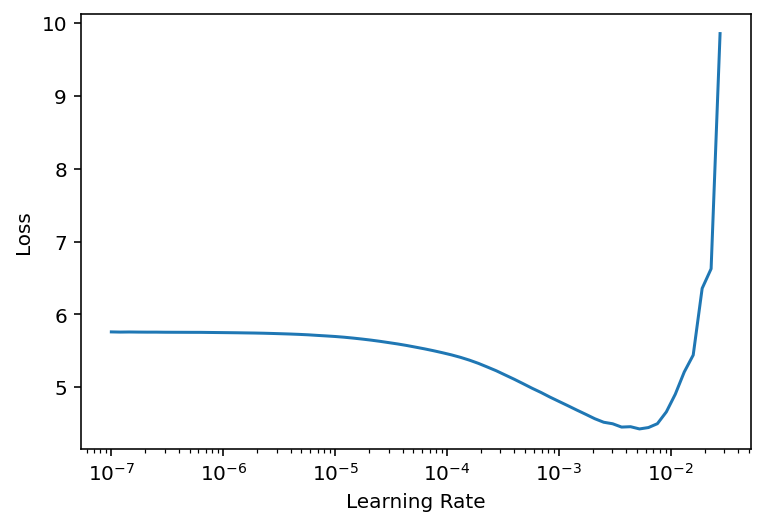

In [18]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(2, lr_max=1e-3, wd=1e-5)
learn.save('fastai_v2_hooktheory')

epoch,train_loss,valid_loss,perplexity,accuracy,time
0,3.953500,2.681561,14.607875,0.355478,00:26
1,3.247480,2.571788,13.089205,0.357583,00:26


/home/ashaw/anaconda3/envs/musicautobot/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Path('../../data/v20/models/fastai_v2_hooktheory.pth')

## Load and predict

In [53]:
from musicautobot.utils.top_k_top_p import top_k_top_p

In [71]:
learn = MusicLearner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=[Perplexity(), accuracy]).load('fastai_v2_hooktheory')

## 5. Predict

---
See [Generate.ipynb](Generate.ipynb) to use a pretrained model and generate better predictions

---

In [72]:
midi_file = base_path/'../midi/notebook_examples/single_bar_example.mid'; midi_file
item = MusicItem.from_file(midi_file, vocab);

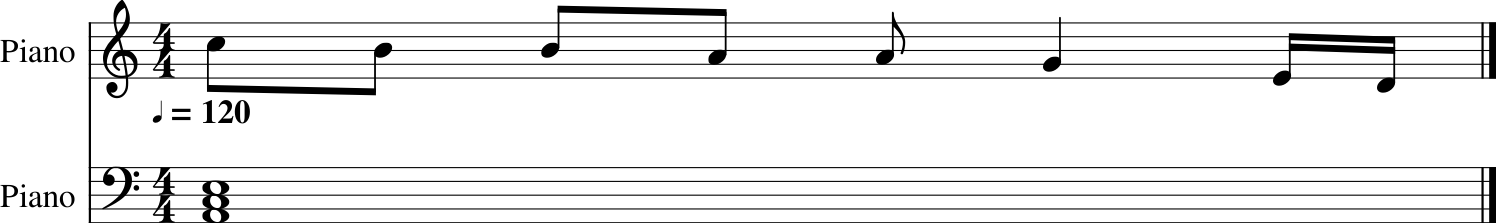

In [73]:
item.show()

Here's what the seed sounds like:

### Start Predictions:

In [74]:
pred, full = learn.predict(item, n_words=100)

Prediction

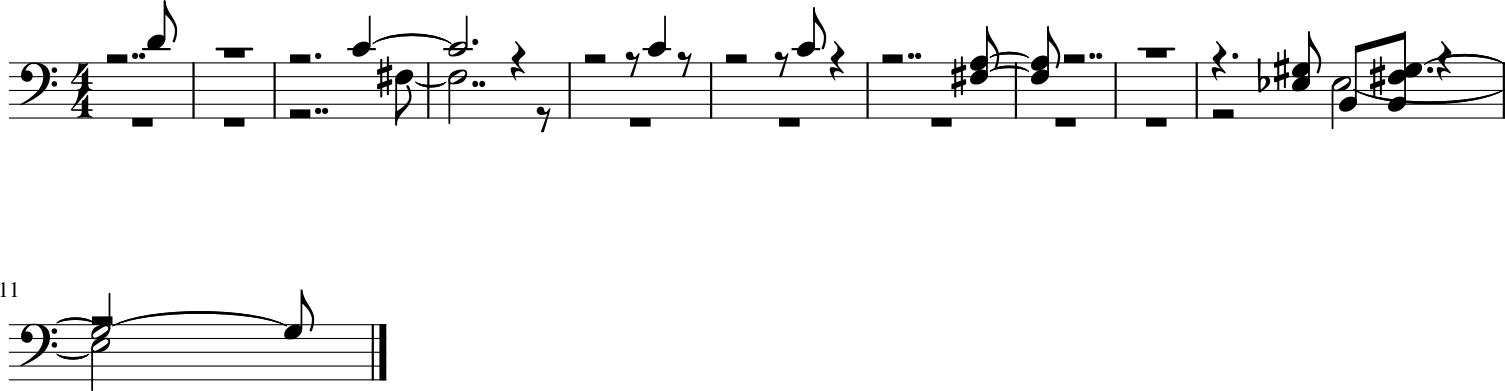

In [67]:
# Prediction
pred.show()

In [68]:
pred.play()